In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from util.true_gaussian_process import *

from ofm_OT_likelihood import *
from models.fno import FNO

import statsmodels.api as sm
from scipy.stats import binned_statistic
import statsmodels.api as sm
from scipy.stats import binned_statistic
from torchvision.transforms.functional import rotate

import os

In [2]:
n_x = 64
dims = [n_x, n_x]


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
spath = Path('your_path/blackhole')

spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# FNO hyperparameters
modes = 32 
width = 128
mlp_width = 128

# GP hyperparameters
kernel_length=0.01
kernel_variance=1
nu = 0.5 # default

## training parameters
epochs = 500
sigma_min=1e-4
N = 1
batch_size = 256

In [3]:
def compute_acovf(z):
    # z shape : [n, ndim, ndim]
    res = z.shape[-1]
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat)
    acf = torch.fft.fftshift(acf).mean(dim=0) / z[0].numel() # ndim*ndim
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means

In [4]:
# currently, we cannot release the source of black hole data to follow the double-blind review process
# we will release the source of the black hole after publication
x_raw = np.load('bh_all.npy')
x_raw = x_raw[:-100] # leave last 100 samples for test

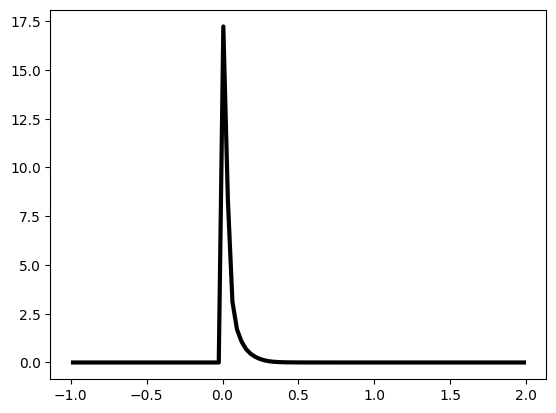

In [5]:
# data augmentation to get more training samples
x_rot0 = torch.Tensor(x_raw).unsqueeze(1)
x_rot1 = rotate(x_rot0, 90)
x_rot2 = rotate(x_rot0, 180)
x_rot3 = rotate(x_rot0, 270)
x_train = torch.vstack([x_rot0, x_rot1, x_rot2, x_rot3])

x_train = x_train + 1e-8

x_hist_true, bin_edges = x_train.histogram(range=[-1,2],density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='k', lw=3, label='Real')
#plt.plot([0,0], [0,0.6], ls='--', lw=2, c='red')

loader_tr = DataLoader(x_train, batch_size=batch_size, shuffle=True)

In [6]:
for i in range(N):
    model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=2, t_scaling=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
    fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)
    fmot.train(loader_tr, optimizer, epochs=epochs, scheduler=scheduler, eval_int=int(0), save_int=int(500), generate=False, save_path=spath,saved_model=saved_model)


tr @ epoch 1/500 | Loss 0.337121 | 16.59 (s)
tr @ epoch 2/500 | Loss 0.054115 | 16.39 (s)
tr @ epoch 3/500 | Loss 0.037409 | 16.40 (s)
tr @ epoch 4/500 | Loss 0.033765 | 16.40 (s)
tr @ epoch 5/500 | Loss 0.029096 | 16.40 (s)
tr @ epoch 6/500 | Loss 0.028699 | 16.40 (s)
tr @ epoch 7/500 | Loss 0.027993 | 16.40 (s)
tr @ epoch 8/500 | Loss 0.025712 | 16.40 (s)
tr @ epoch 9/500 | Loss 0.023722 | 16.40 (s)
tr @ epoch 10/500 | Loss 0.024695 | 16.40 (s)
tr @ epoch 11/500 | Loss 0.025592 | 16.41 (s)
tr @ epoch 12/500 | Loss 0.025071 | 16.40 (s)
tr @ epoch 13/500 | Loss 0.021054 | 16.40 (s)
tr @ epoch 14/500 | Loss 0.023250 | 16.40 (s)
tr @ epoch 15/500 | Loss 0.024581 | 16.40 (s)
tr @ epoch 16/500 | Loss 0.022301 | 16.40 (s)
tr @ epoch 17/500 | Loss 0.022374 | 16.40 (s)
tr @ epoch 18/500 | Loss 0.022959 | 16.40 (s)
tr @ epoch 19/500 | Loss 0.021643 | 16.40 (s)
tr @ epoch 20/500 | Loss 0.021460 | 16.40 (s)
tr @ epoch 21/500 | Loss 0.021786 | 16.40 (s)
tr @ epoch 22/500 | Loss 0.020724 | 16.40 (

tr @ epoch 178/500 | Loss 0.016733 | 16.41 (s)
tr @ epoch 179/500 | Loss 0.016582 | 16.41 (s)
tr @ epoch 180/500 | Loss 0.016383 | 16.41 (s)
tr @ epoch 181/500 | Loss 0.016853 | 16.41 (s)
tr @ epoch 182/500 | Loss 0.016411 | 16.41 (s)
tr @ epoch 183/500 | Loss 0.015723 | 16.41 (s)
tr @ epoch 184/500 | Loss 0.016204 | 16.41 (s)
tr @ epoch 185/500 | Loss 0.015265 | 16.41 (s)
tr @ epoch 186/500 | Loss 0.016305 | 16.41 (s)
tr @ epoch 187/500 | Loss 0.015620 | 16.41 (s)
tr @ epoch 188/500 | Loss 0.015628 | 16.41 (s)
tr @ epoch 189/500 | Loss 0.016587 | 16.41 (s)
tr @ epoch 190/500 | Loss 0.015918 | 16.41 (s)
tr @ epoch 191/500 | Loss 0.015861 | 16.41 (s)
tr @ epoch 192/500 | Loss 0.016171 | 16.41 (s)
tr @ epoch 193/500 | Loss 0.015524 | 16.41 (s)
tr @ epoch 194/500 | Loss 0.016290 | 16.41 (s)
tr @ epoch 195/500 | Loss 0.015982 | 16.41 (s)
tr @ epoch 196/500 | Loss 0.015996 | 16.41 (s)
tr @ epoch 197/500 | Loss 0.014692 | 16.41 (s)
tr @ epoch 198/500 | Loss 0.016052 | 16.41 (s)
tr @ epoch 19

tr @ epoch 353/500 | Loss 0.015601 | 16.40 (s)
tr @ epoch 354/500 | Loss 0.014883 | 16.40 (s)
tr @ epoch 355/500 | Loss 0.015035 | 16.40 (s)
tr @ epoch 356/500 | Loss 0.014491 | 16.40 (s)
tr @ epoch 357/500 | Loss 0.015287 | 16.40 (s)
tr @ epoch 358/500 | Loss 0.015033 | 16.40 (s)
tr @ epoch 359/500 | Loss 0.014196 | 16.40 (s)
tr @ epoch 360/500 | Loss 0.014820 | 16.40 (s)
tr @ epoch 361/500 | Loss 0.015491 | 16.40 (s)
tr @ epoch 362/500 | Loss 0.014825 | 16.40 (s)
tr @ epoch 363/500 | Loss 0.015266 | 16.40 (s)
tr @ epoch 364/500 | Loss 0.015195 | 16.40 (s)
tr @ epoch 365/500 | Loss 0.014825 | 16.40 (s)
tr @ epoch 366/500 | Loss 0.014328 | 16.40 (s)
tr @ epoch 367/500 | Loss 0.015547 | 16.40 (s)
tr @ epoch 368/500 | Loss 0.014529 | 16.40 (s)
tr @ epoch 369/500 | Loss 0.015150 | 16.40 (s)
tr @ epoch 370/500 | Loss 0.015029 | 16.40 (s)
tr @ epoch 371/500 | Loss 0.015183 | 16.40 (s)
tr @ epoch 372/500 | Loss 0.015201 | 16.40 (s)
tr @ epoch 373/500 | Loss 0.014855 | 16.40 (s)
tr @ epoch 37

## load trained model

In [10]:
## load trained model
model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=2, t_scaling=1).to(device)
    
for param in model.parameters():
    param.requires_grad = False
    
# paper :model_path = path "paper_saved_models/{}/1D_codomain_649_set1.pt".format(folder)
model_path = os.path.join(spath, 'epoch_500.pt')
checkpoint = torch.load(model_path, map_location='cpu', weights_only=True)
model.load_state_dict(checkpoint)

fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)

## statistical features

In [8]:
#x_train = torch.exp(x_train*x_std + x_mean)
x_hist_true, bin_edges = x_train.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x)

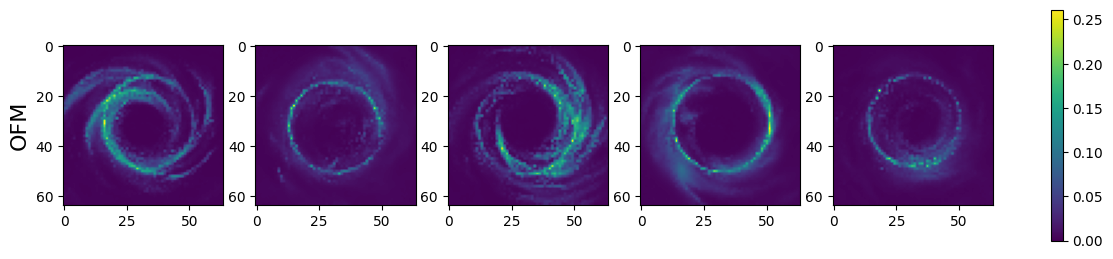

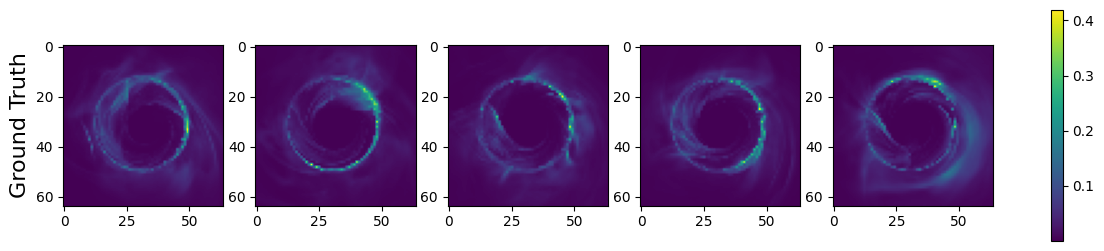

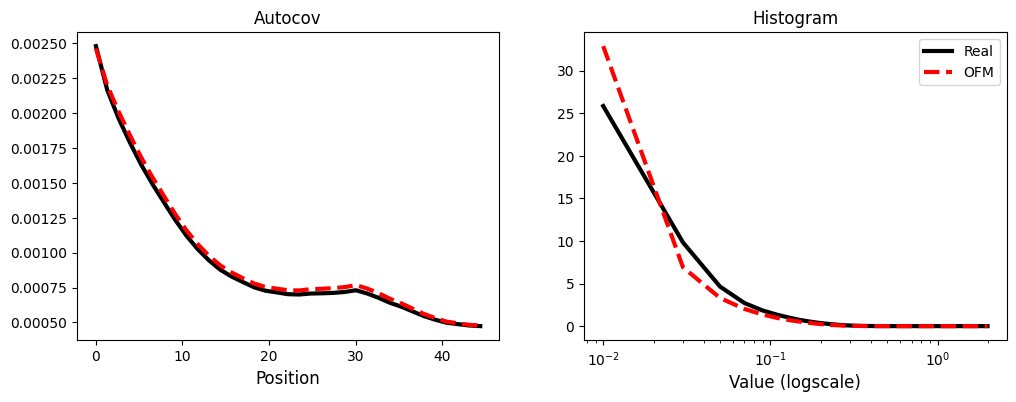

In [36]:
with torch.no_grad():

    X_hat = fmot.sample([n_x, n_x], n_samples=10, n_eval=10).cpu()
    #X_hat = torch.exp(X_hat*x_std + x_mean).squeeze()
    
    X_ground_truth = x_train[:5].squeeze()
    # plot
    
    X_alt = []
    for i in range(5):
        X_temp = fmot.sample([n_x, n_x], n_samples=200, n_eval=10).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    #X_alt = torch.exp(X_alt * x_std + x_mean)
    
    bin_center, x_acovf = compute_acovf(X_alt.squeeze())
    #x_train = torch.exp(x_train*x_std + x_mean)
    _, x_acovf_true = compute_acovf(x_train.squeeze())
    
    x_hist, bin_edges_alt = X_alt.histogram(range=[0,2], density=True)
    x_hist_true, bin_edges = x_train.histogram(range=[0, 2], density=True)
    
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[i,:,:].squeeze()

        ax[i].imshow(x)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('OFM', fontsize=16)
        #ax[0].plot(x_ground_truth)
        #ax[0].set_title('Real')
        #ax[1].plot(x)
        #ax[1].set_title('OpFlow Generated')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])
        
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    bar = ax[4].imshow(x)#, vmin=-2, vmax=2)
    fig.colorbar(bar, ax=ax)
    #plt.show()
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('Ground Truth', fontsize=16)

    bar = ax[4].imshow(x_ground_truth) #, vmin=-2, vmax=2)
    fig.colorbar(bar, ax=ax)
   
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(bin_center, x_acovf_true, c='k', lw=3)
    ax[0].plot(bin_center, x_acovf, c='r',ls='--', lw=3)
    #ax[0].set_ylim(0.2, 0.45)
    ax[0].set_title('Autocov')
    ax[0].set_xlabel('Position', fontsize='large')
    ax[1].plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='k', lw=3, label='Real')
    ax[1].plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='r', ls='--', lw=3, label='OFM')
    ax[1].set_xscale('log')
    ax[1].set_title('Histogram')
    ax[1].legend(loc='upper right')
    ax[1].set_xlabel('Value (logscale)', fontsize='large')
    #plt.savefig("plots/GP2GP/epoch_{}.pdf".format(epoch))

## OFM paper plots

In [11]:
import os

In [15]:

paper_folder = 'blackhole'

if not os.path.exists(f"../Generation_results/{paper_folder}"):
    os.makedirs(f"../Generation_results/{paper_folder}")

In [13]:
x_train = torch.Tensor(x_train)
#x_train = torch.exp(x_train*x_std + x_mean)
x_hist_true, bin_edges = x_train.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x)

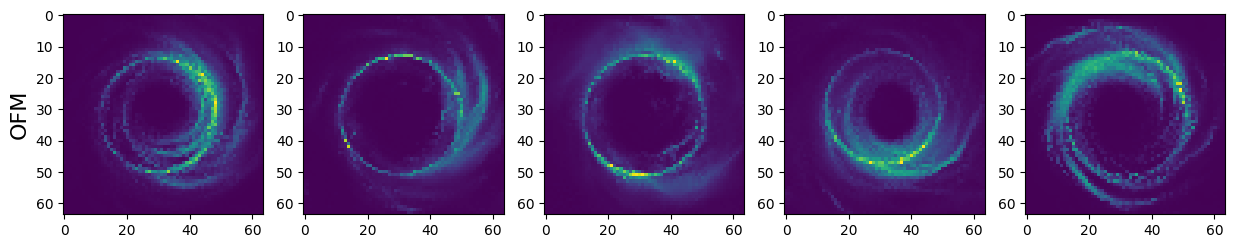

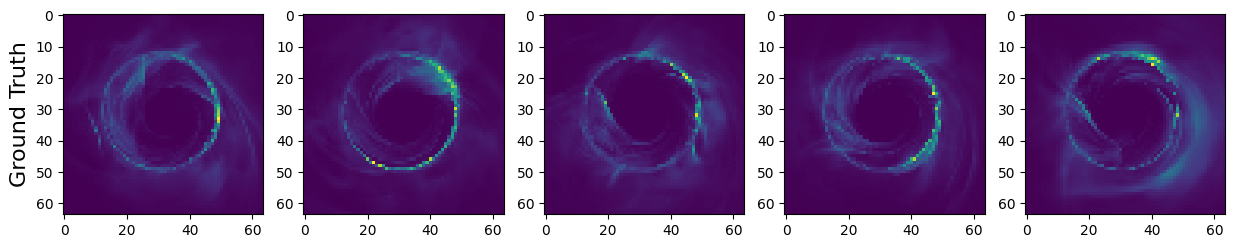

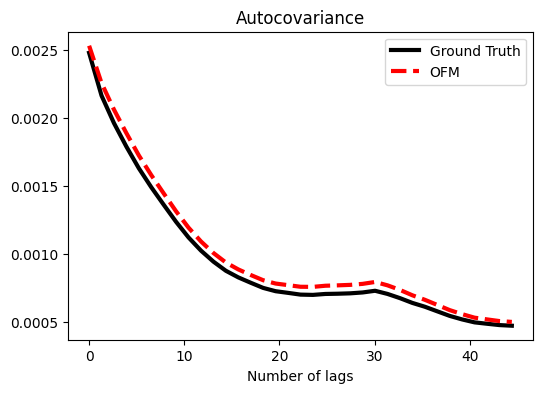

In [17]:
with torch.no_grad():

    X_hat = fmot.sample([n_x, n_x], n_samples=10, n_eval=10).cpu()
    #X_hat = torch.exp(X_hat*x_std + x_mean).squeeze()
    
    X_ground_truth = x_train[:5].squeeze()
    # plot
    
    X_alt = []
    for i in range(5):
        X_temp = fmot.sample([n_x, n_x], n_samples=200, n_eval=10).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    #X_alt = torch.exp(X_alt * x_std + x_mean)
    
    bin_center, x_acovf = compute_acovf(X_alt.squeeze())
    #x_train = torch.exp(x_train*x_std + x_mean)
    _, x_acovf_true = compute_acovf(x_train.squeeze())
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)
    x_hist_true, bin_edges = x_train.histogram(range=[-4, 4], density=True)
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[-i,:,:].squeeze()

        ax[i].imshow(x)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('OFM', fontsize=16)
        
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    #bar = ax[4].imshow(x)#, vmin=-2, vmax=2)
    #fig.colorbar(bar, ax=ax)
    #plt.show()
    plt.savefig(f"../Generation_results/{paper_folder}/bh_samples.pdf")
    
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('Ground Truth', fontsize=16)
    plt.savefig(f"../Generation_results/{paper_folder}/bh_gt_samples.pdf")
    
    #bar = ax[4].imshow(x_ground_truth) #, vmin=-2, vmax=2)
    #fig.colorbar(bar, ax=ax)
   
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.plot(bin_center, x_acovf_true, c='k', lw=3, label='Ground Truth')
    ax.plot(bin_center, x_acovf, c='r',ls='--', lw=3, label='OFM')
    #ax[0].set_ylim(0.2, 0.45)
    ax.set_title('Autocovariance')
    ax.set_xlabel('Number of lags')
    ax.legend(loc='upper right')
    plt.savefig(f"../Generation_results/{paper_folder}/OFM_bh_stat.pdf")

## Super-resolution results

In [18]:
n_x_sup = 128

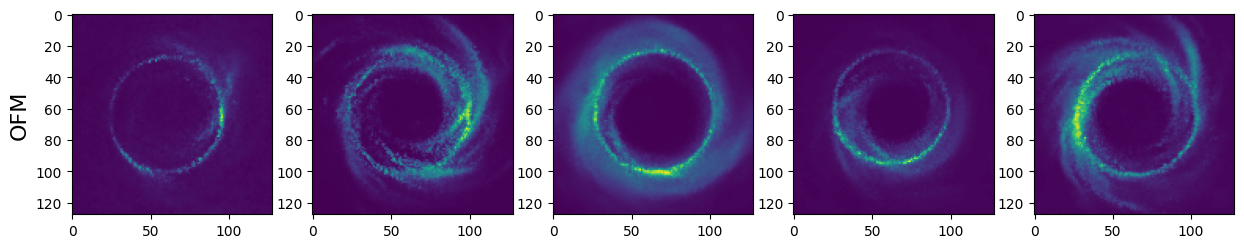

In [19]:
with torch.no_grad():

    X_hat = fmot.sample([n_x_sup , n_x_sup], n_samples=10, n_eval=10).cpu()
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[i,:,:].squeeze()

        ax[i].imshow(x)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('OFM', fontsize=16)
        
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    #bar = ax[4].imshow(x)#, vmin=-2, vmax=2)
    #fig.colorbar(bar, ax=ax)
    #plt.show()
    plt.savefig(f"../Generation_results/{paper_folder}/OFM_bh_samples_sup_{n_x_sup}.pdf")